In [1]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
      data = f.namelist() # list type, element is str "text8" 
      data = f.read(data[0]) #read data as bytes type
      data = tf.compat.as_str(data) #change bytes to str
      data = data.split() # split str with space
      print('Data size %d' % len(data))
    return data

# Read data
filename = './data/text8.zip'
words = read_data(filename)

Data size 17005207


In [3]:
def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]] # unknow words
    # count each words and list as tuple (word, count)
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary) #dict name is word and contest is the index
    data = list() # context is same as words list but transfer to dictionary index
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

vocabulary_size = 50000

data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('words list',words[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
words list ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [4]:
def generate_batch(batch_size, num_words, range_words):
    global data_index #global variable
    #assert batch_size % num_words == 0 #make sure a bag of words can all feed in batch
    assert num_words <= 2 * range_words 
    batch = np.ndarray(shape=(batch_size,num_words), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * range_words + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])# for shifting window in line 24
        data_index = (data_index + 1) % len(data)
    ############################################
    for i in range(batch_size):
        labels[i, 0] = buffer[range_words]
        input_index = range_words  # index which will be picked as buffer[index] for label matrix
        input_to_avoid = [ input_index ] # those indexs will no be picked for lable
        for j in range(num_words):
            while input_index in input_to_avoid:
                input_index = random.randint(0, span - 1) #exclude target already in target_to_avoid
            input_to_avoid.append(input_index) #add picked target to avoid be picked again
            batch[i,j] = buffer[input_index]
     ###########################################      
        buffer.append(data[data_index]) # shift window to right direct with 1 index
        data_index = (data_index + 1) % len(data)
    return batch, labels
###########################################
print('data:', [reverse_dictionary[di] for di in data[:16]])
data_index = 0
num_words = 4
range_words = 2
batch, labels = generate_batch(batch_size=8, num_words=num_words, range_words=range_words)
print('\nwith num_words = %d and range_words = %d:' % (num_words, range_words))
for i in range(8):
    print('    batch_%d:' % i, [reverse_dictionary[bi] for bi in batch[i,:]])
    print('    labels_%d:'% i, [reverse_dictionary[li] for li in labels[i]] )
###########################################

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with num_words = 4 and range_words = 2:
    batch_0: ['anarchism', 'a', 'originated', 'term']
    labels_0: ['as']
    batch_1: ['term', 'originated', 'as', 'of']
    labels_1: ['a']
    batch_2: ['a', 'abuse', 'of', 'as']
    labels_2: ['term']
    batch_3: ['term', 'a', 'abuse', 'first']
    labels_3: ['of']
    batch_4: ['first', 'term', 'used', 'of']
    labels_4: ['abuse']
    batch_5: ['used', 'of', 'against', 'abuse']
    labels_5: ['first']
    batch_6: ['against', 'early', 'abuse', 'first']
    labels_6: ['used']
    batch_7: ['working', 'early', 'first', 'used']
    labels_7: ['against']


In [5]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
range_words = 1 # How many words to consider left and right.
num_words = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.
 
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
 
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size,num_words])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
     
    # Variables.
      #tf.random_uniform(shape, minval=0, maxval=None, dtype=tf.float32, seed=None, name=None)
    embeddings = tf.Variable(
      tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
      tf.truncated_normal([vocabulary_size, embedding_size],
                           stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
     
    # Model.
    # Look up embeddings for inputs.
    ###########################################
    embed = tf.zeros([batch_size, embedding_size])
    for i in range(num_words):
        embed += tf.nn.embedding_lookup(embeddings, train_dataset[:,i])
    ###########################################
     
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                                     labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
   
    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    #optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
     
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
    print (normalized_embeddings.get_shape)
 

<bound method Tensor.get_shape of <tf.Tensor 'truediv:0' shape=(50000, 128) dtype=float32>>


In [6]:
num_steps = 100001
 
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, num_words, range_words)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
      # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1] # argsort function is sorting from small to big 
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.444926
Nearest to with: universitat, spares, barada, materialist, barbarous, imitated, plough, bodied,
Nearest to to: maturing, duns, worldcon, mclaren, zaire, recitative, inadequate, beg,
Nearest to about: ial, urey, crt, mandates, crono, piaget, amplifying, cfaf,
Nearest to no: amal, fenwick, xor, abortions, cheek, underlies, addicts, suspend,
Nearest to many: bletchley, distinctly, gandy, migr, kon, guys, prevenient, roc,
Nearest to that: kodiak, by, twenty, females, ross, payroll, subdominant, germain,
Nearest to more: fet, hospitable, fuse, longitude, demonolatry, brushing, penitentiary, tristar,
Nearest to this: nextstep, elsa, mikhail, teachings, dx, fridtjof, trax, gordian,
Nearest to are: caves, andronicus, minivans, hurd, networking, norsemen, dde, fastest,
Nearest to they: suffrage, retake, manufactured, perceptions, fade, kzinti, prefer, encyclopaedia,
Nearest to however: rterbuch, shutdown, offset, violating, atolls, instincts, parerga

Nearest to states: newsreels, tea, limelight, residual, printing, agronomy, state, nations,
Average loss at step 52000: 3.079758
Average loss at step 54000: 3.056651
Average loss at step 56000: 3.049029
Average loss at step 58000: 2.959869
Average loss at step 60000: 3.031023
Nearest to with: between, under, while, within, southwards, through, in, although,
Nearest to to: would, will, must, could, might, can, catalyse, geraldine,
Nearest to about: over, spoiling, repellent, niches, erection, that, shogunate, strive,
Nearest to no: kms, rana, a, any, bertolucci, consistently, tops, never,
Nearest to many: some, several, these, most, all, planing, norway, doorstep,
Nearest to that: which, however, mildly, this, ross, inheritance, about, rawlinson,
Nearest to more: most, less, transitioned, riches, very, inti, meso, smaller,
Nearest to this: which, it, the, heckman, aloft, that, unfairness, conceiving,
Nearest to are: were, have, is, be, include, including, ctrl, emphatically,
Nearest to 

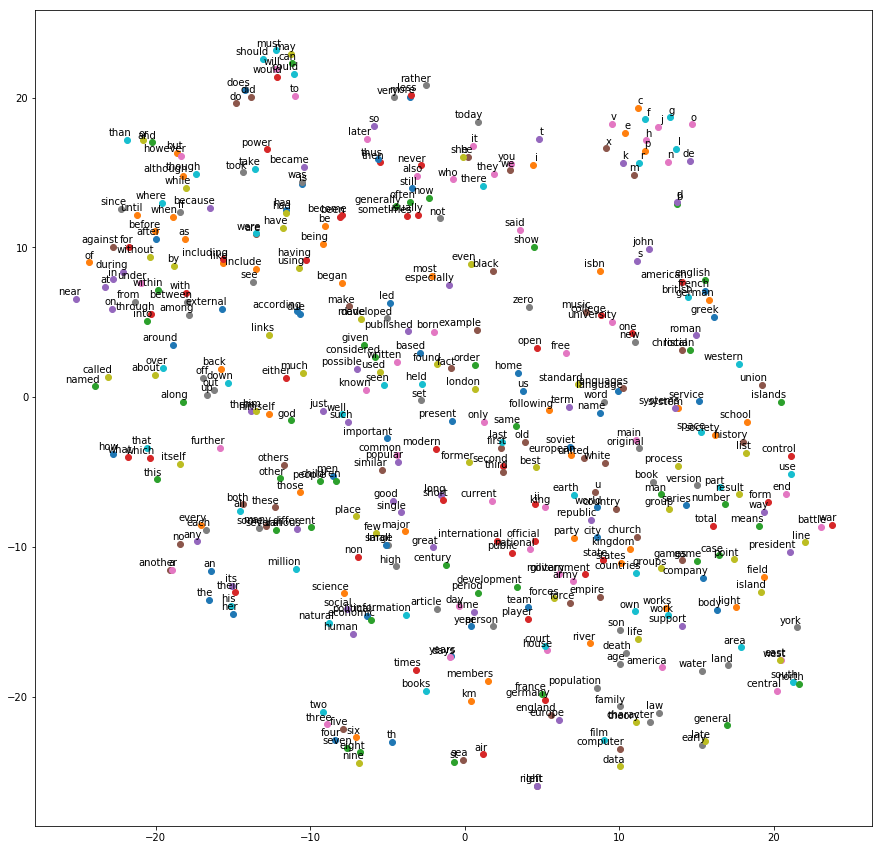

In [7]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

num_points = 400
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)